# AI Training

## Cargado de Datos

Se trabaja con la base de datos llamada **merged_dataset_seven_sentiments.csv**, que se obtiene corriendo el codigo del archivo **Unify_dataset.ipynb**


los sentimientos usados son
| sadness | joy/happ | love | anger | fear | surprise | neutral |
|---------|-----|------|-------|-----|------|-------|
| 0      | 1  | 2   | 3   |  4  | 5    | 6     | 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from joblib import dump

In [4]:
df=pd.read_csv('./Modeloscsv/merged_dataset_seven_sentiments.csv')
df

,text,label
0,i always feel ashamed for losing my temper at ...,0.0
1,i just want to tell people i feel humiliated,0.0
2,i was feeling rotten but i didnt let that be a...,0.0
3,i started missing my natural hair colour and f...,0.0
4,i am tired of feeling beaten and bruised and s...,0.0
...,...,...
509330,So many players from the current crop are goin...,6.0
509331,:((,6.0
509332,"Hi , do you know what ’ s for dinner ? I ’ m s...",6.0
509333,But I still think AC milan's defence seems bet...,6.0


In [5]:
df = df.dropna()
df.isnull().sum()

text     0
label    0
dtype: int64

## Visualización de Datos

<Axes: title={'center': 'Count of Sentiments'}, xlabel='label'>

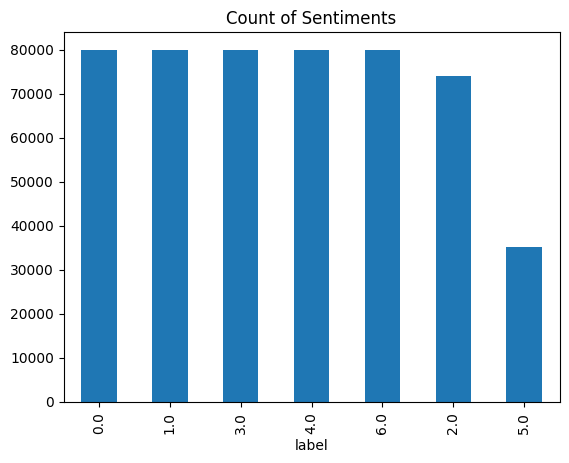

In [6]:
sentiment_count = df.label.value_counts()
sentiment_count.plot(kind="bar", title="Count of Sentiments")

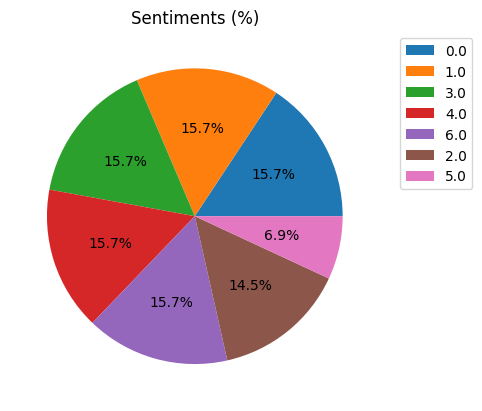

In [7]:
labels = df["label"].value_counts().index
plt.pie(df["label"].value_counts(), autopct='%1.1f%%')
plt.legend(labels, bbox_to_anchor=(1.27, 1))
plt.title("Sentiments (%)")
plt.show()

## Preprocesado de datos

In [8]:
df["label"].unique()

array([0., 1., 2., 3., 4., 5., 6.])

In [10]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import nltk
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/davidcv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/davidcv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:

# Contraction dictionary
contractions = {
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'll": "he will",
    "he's": "he is",
    "I'd": "I had",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "let's": "let us",
    "mightn't": "might not",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she had",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they had",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we had",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where's": "where is",
    "who's": "who had",
    "who'll": "who will",
    "who're": "who are",
    "who's": "who is",
    "who've": "who have",
    "won't": "will not",
    "wouldn't": "would not",
    "wouldnt": "would not",
    "you'd": "you had",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",
    "arent": "are not",
    "cant": "cannot",
    "couldnt": "could not",
    "didnt": "did not",
    "doesnt": "does not",
    "dont": "do not",
    "hadnt": "had not",
    "hasnt": "has not",
    "havent": "have not",
    "Id": "I had",
    "Ill": "I will",
    "Im": "I am",
    "Ive": "I have",
    "isnt": "is not",
    "lets": "let us",
    "mightnt": "might not",
    "mustnt": "must not",
    "shouldnt": "should not",
    "werent": "were not",
    "gonna": "going to",
    "imma": "i am going to"
}

In [12]:
import unicodedata


def clean_text(text):

    # lower case conversion
    text = text.lower()

    # Decontrating: rewriting text without the contrations. Ex.: I'm = I am; aren't = are not ...
    if type(text) is str:
        for key in contractions:
            value = contractions[key]
            text = text.replace(key, value)

    # remove emails
    text = re.sub(
        r"([a-zA-Z0-9+._-]+@[a-zA-Z0-9+._-]+\.[a-zA-Z0-9+._-]+)", " ", text)

    # remove hyperlink
    text = re.sub(
        r"(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?", " ", text)

    # remove rt
    text = re.sub(r"RT[\s]+", "", text)

    # Remove empty spaces
    text = " ".join([t.strip() for t in text.split()])

    # Deleting user mention (@user):
    text = re.sub(r"@[A-Za-z0-9]+", "", text)

    # remove accented characters
    text = unicodedata.normalize("NFKD", text).encode(
        "ascii", "ignore").decode("utf-8", "ignore")

    # remove remaining special caracters
    text = re.sub(r"[^A-Za-z\s]", "", text)

    return text

In [13]:
df["text"] = df["text"].apply(clean_text)

In [16]:
!python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load('en_core_web_sm')


def filter_words(tweet):

    # remove stop words
    stop_words = set(stopwords.words("english"))
    tweet = " ".join([word for word in tweet.split()
                     if word not in stop_words])

    # convert verbs into root form
    tweet_list = []
    for token in nlp(tweet):
        lemma = str(token.lemma_)
        if lemma == "-PRON-" or lemma == "be":
            lemma = token.text
        tweet_list.append(lemma)
    tweet = " ".join(tweet_list)

    return tweet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 220.0 kB/s eta 0:00:00m eta 0:00:010:00:02

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [17]:
df["text"] = df["text"].apply(filter_words)

In [18]:
df["text"]

0                      always feel ashamed lose temper book
1                           want tell people feel humiliate
2                      feel rotten let excuse ease friction
3         start miss natural hair colour feeling bit reg...
4         tired feeling beat bruise sometimes even know ...
                                ...                        
509330    many player current crop go end game crazy thi...
509331                                                     
509332                                hi know dinner starve
509333     still think ac milans defence seem well organize
509334                                                fever
Name: text, Length: 509335, dtype: object

## Entrenamiento del Modelo

In [19]:
df_train, df_test = train_test_split(df , test_size=0.2 , random_state=50)

In [20]:
df_train

,text,label
343958,still figure like set flat uphill flat droppin...,4.0
277391,I m feel enrage another person action consider...,3.0
39123,feel stress kid vulnerability,0.0
204258,feel generous behave well today might persuade...,2.0
148745,say dentist make feel really reassure,1.0
...,...,...
441633,oh mean time world control individual land own...,6.0
153709,feel hopeful,1.0
239499,feel someone insult publically sue defamation,3.0
103904,stress worried lack movement feel shelby reass...,1.0


In [21]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_train

<407468x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 2821430 stored elements in Compressed Sparse Row format>

In [22]:
X_test = vectorizer.transform(df_test['text'])
X_test

<101867x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 704089 stored elements in Compressed Sparse Row format>

In [23]:
Y_train = df_train['label']
Y_test = df_test['label']

In [24]:
model = LogisticRegression(max_iter=1500)
model.fit(X_train, Y_train)
print("Train acc:", model.score(X_train, Y_train))
print("Test acc:", model.score(X_test, Y_test))

Train acc: 0.8634911207751284
Test acc: 0.8560279580236976


In [25]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)
P_train

array([5., 3., 3., ..., 3., 1., 0.])

In [26]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.87459196, 0.02528249, 0.01348085, 0.03454175, 0.02650659,
        0.0049592 , 0.02063716],
       [0.02147143, 0.81436742, 0.07788474, 0.01028254, 0.00945431,
        0.01376735, 0.05277222],
       [0.01264225, 0.04693287, 0.90345768, 0.00781092, 0.00542051,
        0.00309743, 0.02063834],
       [0.026876  , 0.01321103, 0.00914128, 0.85164199, 0.03017876,
        0.00328711, 0.06566384],
       [0.02143158, 0.0106222 , 0.00572445, 0.02333453, 0.85587497,
        0.04972626, 0.03328602],
       [0.01300078, 0.02882781, 0.00946796, 0.00816081, 0.07698015,
        0.76100473, 0.10255776],
       [0.01044513, 0.0189074 , 0.01334915, 0.01308373, 0.00605786,
        0.00896189, 0.92919484]])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  1.,  1.,  0.,  1.,
         0.,  0.,  2.,  2.,  1.,  2.,  2.,  1.,  1.,  1.,  4.,  1.,  1.,
         3.,  1.,  4.,  2.,  2.,  3.,  0.,  0.,  1.,  1.,  7.,  2.,  5.,
         7.,  5.,  6.,  6.,  8.,  7.,  5.,  7.,  6.,  6.,  6.,  8., 11.,
         7.,  9.,  7.,  6.,  5.,  4., 13.,  8.,  1.,  8.,  8.,  3.,  4.,
         8.,  5.,  7.,  3.,  2.,  7.,  0.,  2.,  3.,  8.,  3.,  6.,  6.,
         9., 11., 10., 17., 23., 27., 31., 41., 29., 46., 59., 59., 74.,
        71., 71., 70., 75., 79., 94., 61., 79., 72., 68., 50., 58., 48.,
        44., 36., 33., 23., 17., 15., 20., 11., 10., 13., 10.,  4.,  4.,
         3.,  3.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  2.,  0.,  1.,
         0.,  1.,  0.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.

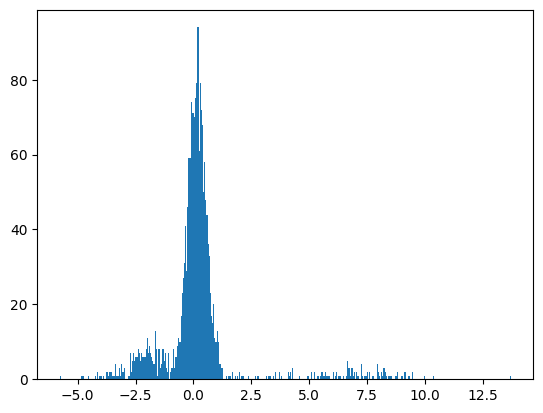

In [27]:
plt.hist(model.coef_[0], bins=400)

In [28]:
mi_oracion = "this text i so complicated im impacient"
mi_oracion_vectorizada = vectorizer.transform([mi_oracion])
sentimiento_predicho = model.predict(mi_oracion_vectorizada)
print("Sentimiento predicho para la oración:", sentimiento_predicho)

Sentimiento predicho para la oración: [6.]


In [48]:
sentiments = {"sad": 0, "happy": 1, "love": 2, "angry": 3, "fear": 4, "surprise": 5, "anxious": 6, "neutarl": 7}

def expression_check(prediction_input):
  for i, prediction in enumerate(prediction_input):
    sentiment = next((key for key, value in sentiments.items() if value == prediction), None)
    if sentiment is not None:
      print(f"Input statement {i} has {sentiment} sentiment")
    else:
      print(f"Input statement {i} has unknown sentiment")


In [53]:
def sentiment_predictor(input):
  input = [clean_text(text) for text in input]
  input = [filter_words(text) for text in input]
  transformed_input = vectorizer.transform(input)
  prediction = model.predict(transformed_input)
  expression_check(prediction)

In [50]:
input = [
    "I'm truly devastated to hear about this news. My heart goes out to you during this difficult time. If there's anything I can do to support you, please don't hesitate to reach out. We're all here for you. 😔",

    "I'm absolutely overjoyed to hear this wonderful news! Congratulations on this incredible achievement! You've worked so hard, and it's truly paying off. Wishing you continued success and happiness. 🎉",

    "Love is such a beautiful thing, and it's wonderful to see it shining through. Your love for each other is inspiring and heartwarming. Wishing you both a lifetime of happiness together. 💕",

    "I'm seething with anger over this situation. It's completely unacceptable, and I understand why you're feeling frustrated. Let's work together to find a solution and make things right. We won't let this stand. 😡",

    "The unknown can be terrifying, and it's completely normal to feel anxious about what lies ahead. Just know that you're not alone. We're here to support you every step of the way, and together, we'll get through this. 😨",

    "What an unexpected and delightful surprise! It's moments like these that remind us of the beauty and joy in life. Let's savor this moment and cherish the memories it brings. 😯",

    "I understand that you're feeling apprehensive about the outcome, but remember, you've done everything you can to prepare. Now it's time to trust in yourself and stay positive. We're all rooting for you, and no matter what happens, we'll be here to support you. 🤞",

    "Everything may seem calm on the surface, but I can sense the tension in the air. It's important to stay vigilant and prepared for whatever may come our way. Let's keep a watchful eye and be ready to act if needed. 😐"
]

In [52]:
sentiment_predictor(input)

Input statement 0 has anxious sentiment
Input statement 1 has happy sentiment
Input statement 2 has happy sentiment
Input statement 3 has angry sentiment
Input statement 4 has fear sentiment
Input statement 5 has surprise sentiment
Input statement 6 has fear sentiment
Input statement 7 has anxious sentiment


## Saving the model

In [55]:
dump(model, 'Modeloscsv/modelo_AI.pkl')

['Modeloscsv/modelo_AI.pkl']